## Today you are a Machine Learning Engineer at the Department of Marketing and Inventory @Walmart Labs.
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store

This work is motivated by the publication https://arxiv.org/pdf/2102.01625.pdf

Further details on data processing available at:
https://arxiv.org/pdf/2010.02503.pdf


Business Problem
* Funnel analysis
    - where people are dropping off
        - a link is broken or the next page takes too long to load
    - causal analysis
        - A/B testing -> increase conversion
* Sales funnel
    - View -> cart -> purchase
    - Behavior
        - Purchase
        - Don't purchase
    - Messiness here
        - Walmart labs employee
            - all the server data
                - connect the sessions
                - where wer have cookies
            - two people use the same computer account -> does it matter?
        - 
        
        
Tree Based models
* y ~ f(x) where x is weekdays
* If we could learn y as a highly non-linear functin of x, then we actually would just be fine
* models need to have flexibility in learning non-linear functinos of x

decision trees
* use one-hot encoding of a continuous variable if it turns out that was the optimal thing to do

non-linear
* polynomial expansion

## You have access to the Walmart server data, specifically the Electronics section, such that you have NO customer facing information, but, only access to timestamped data regarding product viewing/carting/purchasing as follows.

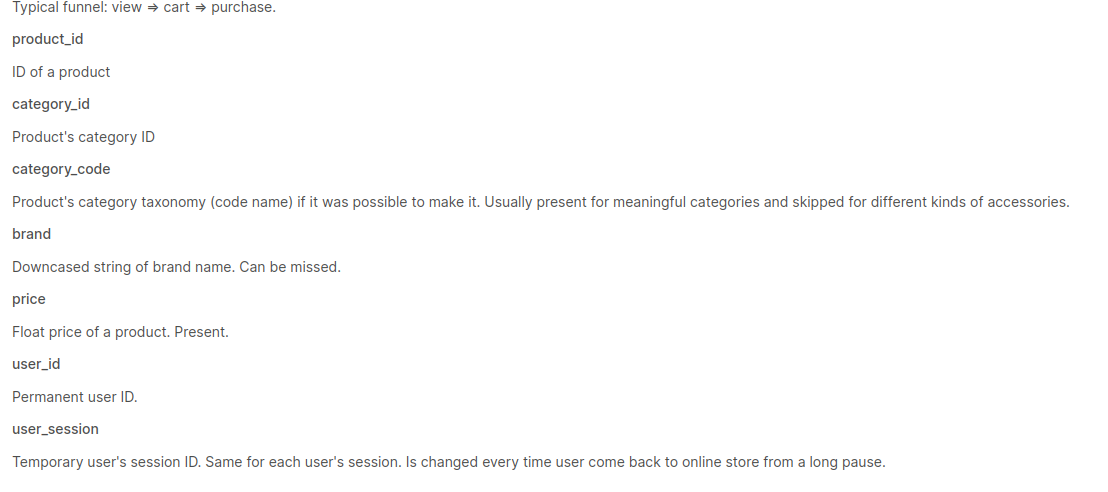

In [1]:
from IPython.display import Image
Image(filename='image1.png')

## The first step is to convert session level information to User-journey level data, i.e. track time stamps from a particulat userID-Product ID combination over time to see if the combination results in a purchase (Y=1) or not (Y=0). The user journey level features extracted for this data set looks as follows:

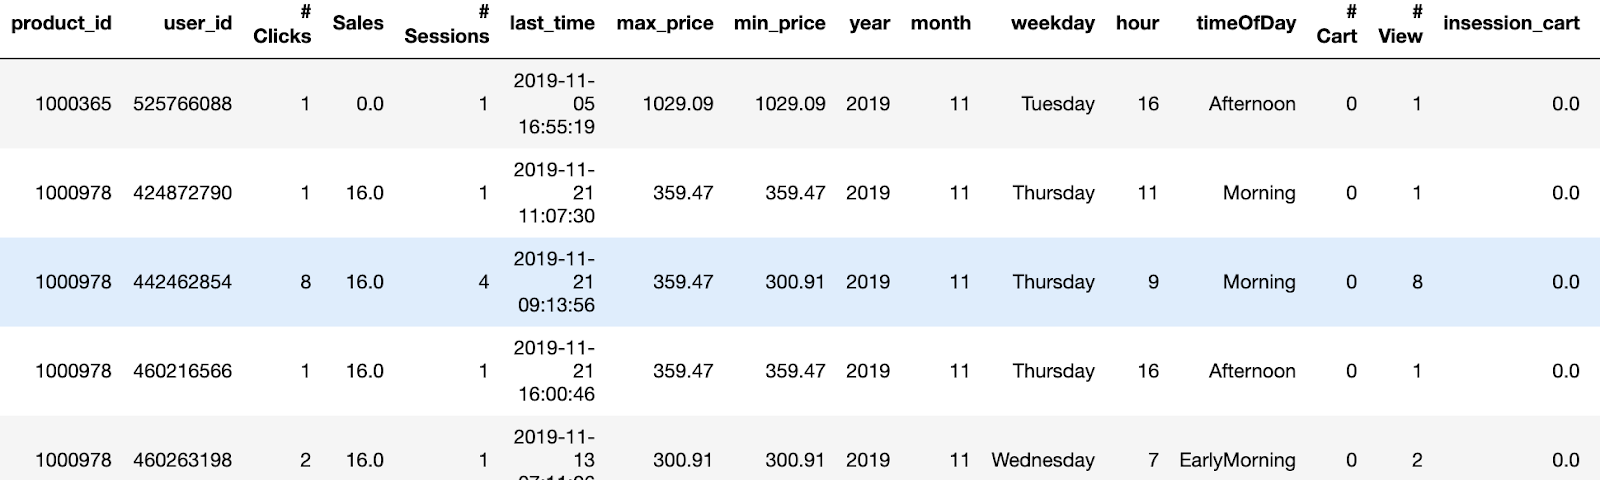

In [2]:
Image(filename='image10.png')

## You have access to user journey level data. Your goal is to perform the following:
## A. To identify what features are most important to classify purchasing customers from non-purchasing customers
## B. To predict a purchasing customer-product interaction from a no-purchasing one. The goal is to build the "best" data model with regards to Recall and F1-score.

# Task 0 (Initialization): Understand the Data!

In [3]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

### Read in the training data, print its shape, and display its first few rows

In [4]:
### START CODE HERE ###
X_train = pd.read_csv('X_train.csv')
print(X_train.shape)
X_train.head()
### END CODE HERE ###

(645816, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0


## Data Wrangling!

### Find the non-numeric features

In [5]:
### START CODE HERE ###
nonNumFeat = X_train.dtypes[X_train.dtypes == object].index.tolist()
nonNumFeat
### END CODE HERE ###

['weekday', 'timeOfDay']

### Print the unique values of the non-numeric features

In [6]:
### START CODE HERE ###
X_train.weekday.unique()
### END CODE HERE ###

array(['Sat', 'Fr', 'Thu', 'Mon', 'Tue', 'Wed', 'Sun'], dtype=object)

In [7]:
X_train.timeOfDay.unique()

array(['Morning', 'Dawn', 'Afternoon', 'Noon', 'Evening', 'EarlyMorning',
       'Night'], dtype=object)

### Convert the non-numeric features to numeric

Remember, these feature values are ordered temporally

In [8]:
X_train['weekday'] = X_train['weekday'].replace(
    ['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],
    [1,2,3,4,5,6,7]
)
### START CODE HERE ###
X_train['timeOfDay'] = X_train.timeOfDay.replace(
    ['Dawn', 'EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'],
    [1, 2, 3, 4, 5, 6, 7]
)
### END CODE HERE ###
print(X_train.shape)
X_train.head()

(645816, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,6,3,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,5,1,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,4,5,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,1,4,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,2,4,0,0


## Now do the same with the test data

### First, read it in, then print its shape and first few rows

In [9]:
### START CODE HERE ###
X_test = pd.read_csv('X_test.csv')
print(X_test.shape)
X_test.head()
### END CODE HERE ###

(430544, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,2019,11,Wed,EarlyMorning,0,0
1,2,2,182.0,118.38,118.38,0,2,0,1,2019,11,Fr,EarlyMorning,0,0
2,1,1,0.0,63.77,63.77,0,1,0,1,2019,11,Fr,Morning,0,0
3,1,1,0.0,32.18,32.18,0,1,0,3,2019,11,Fr,EarlyMorning,0,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,2019,11,Sat,EarlyMorning,0,0


### Convert the non-numeric features

In [10]:
### START CODE HERE ###
X_test['weekday'] = X_test['weekday'].replace(
    ['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],
    [1,2,3,4,5,6,7]
)
X_test['timeOfDay'] = X_test.timeOfDay.replace(
    ['Dawn', 'EarlyMorning', 'Morning', 'Noon', 'Afternoon', 'Evening', 'Night'],
    [1, 2, 3, 4, 5, 6, 7]
)
### END CODE HERE ###
print(X_test.shape)
X_test.head()

(430544, 15)


,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,126.86,126.86,0,1,0,1,2019,11,3,2,0,0
1,2,2,182.0,118.38,118.38,0,2,0,1,2019,11,5,2,0,0
2,1,1,0.0,63.77,63.77,0,1,0,1,2019,11,5,3,0,0
3,1,1,0.0,32.18,32.18,0,1,0,3,2019,11,5,2,0,0
4,1,1,0.0,1093.72,1093.72,0,1,0,2,2019,11,6,2,0,0


### Determine the fractions of user journeys which result in purchases in both the training and test datasets. Are the datasets balanced?

In [11]:
### START CODE HERE ###
# Extract the 'Purchase' columns of the datasets as your targets
y_train = X_train.Purchase.values
y_test  = X_test.Purchase.values
# You can change the wording of the print() commands from "Percentage" to "Fraction" if you prefer
print(f'Percentage of purchases in training = {(np.sum(y_train)*100)/len(y_train)}') 
print(f'Percentage of purchases in test = {(np.sum(y_test)*100)/len(y_test)}')
### END CODE HERE ###

Percentage of purchases in training = 1.3900244032355966
Percentage of purchases in test = 1.421457504924003


---
# Task 1 (Instructor Led): To find the optimal set of features for this data set. Visualize each feature's contribution to separate Purchase=0 from Purchase=1, and select the top two features (for scatter plot)
    

In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
print(f'The training data currently has {X_train.shape[1]} features')

The training data currently has 15 features


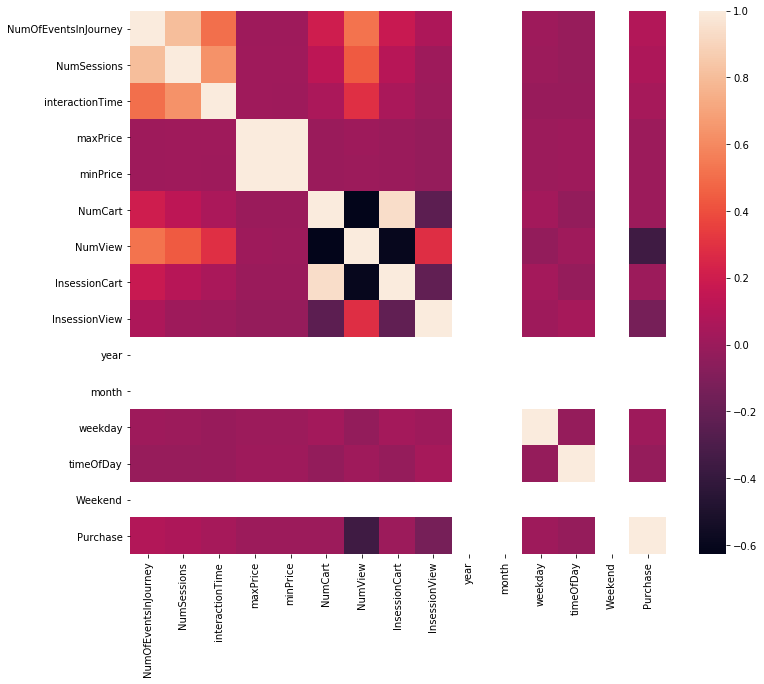

In [13]:
#Visual inspection of features
plt.figure(figsize=(12,10))
### START CODE HERE ###
# Compute the Pearson Correlation of each feature in the training df
cor = X_train.corr()
### END CODE HERE ###
# Plot the correlations
sns.heatmap(cor)
plt.show()
# Some intersting correlations pop up that need further analysis (later)
# we need to eliminate features that have very high absolute correlations

### Fill (replace) NaN values in the correlation matrix with 1 so the associated features (with no variance) can be removed

In [14]:
### START CODE HERE ###
cor = cor.fillna(1.0)
### END CODE HERE ###

### Drop features with high correlations

In [15]:
### START CODE HERE ###
# Initialize a list indicating whether to keep a column in the training df
# For now, set all entries to True
keep_columns = [True]*len(cor.columns.tolist())
# Loop over all columns
for i in range(len(keep_columns)-2):
    # Loop over all columns to the right of the current one
    for j in range(i+1, len(keep_columns)-1):
        # If the absolute correlation between the current two columns is greater 
        # than or equal to 0.8, or no correlation 0 value...
        if abs(cor.iloc[i, j]) >= 0.8:
            # If we haven't already told the keep_columns list to drop column j...
            if keep_columns[j]:
                # Drop column j
                keep_columns[j] = False
# Extract the columns to keep from the training df
selected_columns = [c for c, k, in zip(cor.columns.tolist(), keep_columns) if k]
# Make a new df with the columns we've decided to keep from the training df
X_out = X_train[selected_columns]
### END CODE HERE ###
print('The following columns are present in the new data:')
print(selected_columns)
print(f'The old data had {X_train.shape[1]} features. The new df has {X_out.shape[1]} features.')
print("Shape of y:", y_train.shape)
X_out.head()

The following columns are present in the new data:
['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart', 'NumView', 'InsessionView', 'Purchase']
The old data had 15 features. The new df has 7 features.
Shape of y: (645816,)


,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,Purchase
0,1,0.0,154.41,0,1,1,0
1,1,0.0,92.67,0,1,1,0
2,1,0.0,155.71,0,1,1,0
3,1,0.0,898.32,0,1,1,0
4,1,0.0,146.21,0,1,1,0


### Feature Selection on p-value (statistical significance to Y value)

In [16]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(X_out.values, y_train, SL, selected_columns)

In [17]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {X_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart', 'NumView', 'InsessionView', 'Purchase']
After selection by Pearson Correlation, we had 7 features.
After selection by p-value, we have 7 features.


### Visualize the selected features

Ignore the warning messages about distplot. I should replace it with displot, but I haven't figured out how to overlay plots with it.

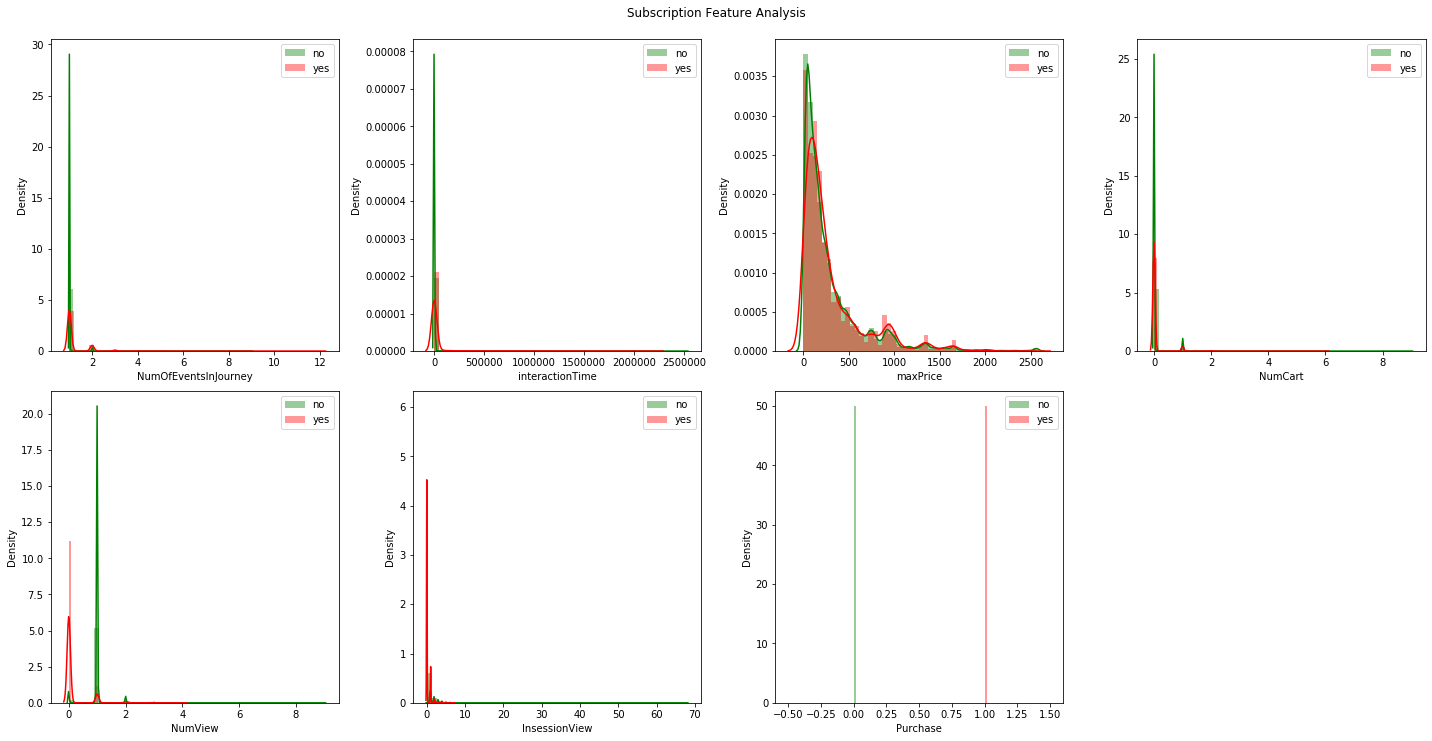

In [18]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize = (20, 15))
j = 0
for i in data_red.columns:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.distplot(data_red[i][data_red['Purchase']==0], color='g', label = 'no')
    sns.distplot(data_red[i][data_red['Purchase']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Drop purchase from the features of X_train and X_test and scale the features so the max norm of each feature is 1. Also, convert the X DataFrames and y Series to NumPy arrays for use with the visualization convenience function which we'll set up next.

In [19]:
from sklearn.preprocessing import normalize
# Note that this function outputs NumPy arrays by default
### START CODE HERE ###
X_train = X_out.drop(columns='Purchase')
X_train = normalize(X_train, axis=0, norm='max')
y_train = y_train
### END CODE HERE ###

In [20]:
### START CODE HERE ###
X_test = X_test.loc[:,keep_columns].drop(columns='Purchase')
X_test = normalize(X_test, axis=0, norm='max')
y_test = y_test
### END CODE HERE ###
print(X_train.shape)
print(X_test.shape)

(645816, 6)
(430544, 6)


Feature ranking:
1. feature 3 (0.501193)
2. feature 4 (0.367738)
3. feature 5 (0.093052)
4. feature 0 (0.028238)
5. feature 1 (0.007418)
6. feature 2 (0.002363)


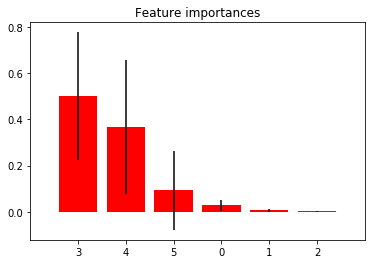

In [21]:
#Use Random Forest to get feature ranks/importances for each feature
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [22]:
X_out.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'Purchase'],
      dtype='object')

## Thus features 3 and 4 (numcart, numview) are the top two rated features that can be used to visualize. Let's set up a convenience function for this purpose.

Note that `X`, `y`, and `yhat` must be NumPy arrays for this function to work

In [23]:
# This function visualizes the classification output on scatter plot
# Feature 1 (Interaction Time is used to observe the impact of low ranked feature)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
def visualize_scatter_plot(X, y, yhat, title):
    loc00=np.where((y==0) & (yhat==0),1,0) # TN: blue
    loc10=np.where((y>0) & (yhat==0),1,0)  # FN: cyan
    loc11=np.where((y>0) & (yhat>0),1,0)   # TP: red
    loc01=np.where((y==0) & (yhat>0),1,0)  # FP
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(X[np.where(loc00>0),3],X[np.where(loc00>0),4],X[np.where(loc00>0),1],color='blue', marker='o')
    ax.scatter3D(X[np.where(loc10>0),3],X[np.where(loc10>0),4],X[np.where(loc10>0),1],color='cyan', marker='o')
    ax.scatter3D(X[np.where(loc11>0),3],X[np.where(loc11>0),4],X[np.where(loc11>0),1],color='red', marker='^')
    ax.scatter3D(X[np.where(loc01>0),3],X[np.where(loc01>0),4],X[np.where(loc01>0),1],color='green', marker='^')
    ax.set_xlabel('NumCart')
    ax.set_ylabel('NumViews')
    ax.set_zlabel('InteractionTime')
    plt.title(title)
    plt.show()

---
# Task 2. Fit a linear model. Pick from SVM, LR. Report results
Ensure each model is the fitted with the best hyperparameters. That includes mitigating the effects of any class imbalances.

### Import models, metrics, and convenience functions

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

### Instantiate, train, and predict with the model

Remember to use the test data when making and evaluating the predictions

In [25]:
### START CODE HERE ###
scaler = StandardScaler()
# regb = LogisticRegression(class_weight='balanced').fit(scaler.fit_transform(X_train), y_train)
# reg_predb = regb.predict(scaler.transform(X_test))

regb = LogisticRegression(class_weight='balanced', random_state=0).fit(X_train, y_train)
reg_predb = regb.predict(X_test)
### END CODE HERE ###

### Evaluate the predictions

Accuracy = 0.999, Precision = 0.944, Recall = 0.990, F1-score = 0.967
Confusion Matrix is:
[[424065    359]
 [    60   6060]]


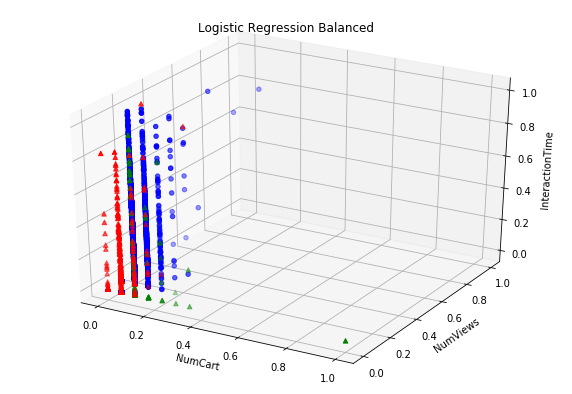

In [26]:
### START CODE HERE ###
cmlog = confusion_matrix(y_test, reg_predb)
acc   = accuracy(y_test, reg_predb)
rec   = recall(y_test, reg_predb)
prec  = precision(y_test, reg_predb)
f1    = f1_score(y_test, reg_predb)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, F1-score = {f1:.3f}')
print('Confusion Matrix is:')
print(cmlog)
visualize_scatter_plot(X_test,y_test,reg_predb,'Logistic Regression Balanced')
#No improvement

---
# Task 3: Fit a Non-Linear Classifier, select from NN, Random Forest, Gradient Boosted Trees

### Unless you already know to use a deep learning framework, DON'T try running an NN classifier in Colab. Scikit-Learn doesn't offer GPU support, so training one of its neural networks will take forever. Your local system might be able to exploit CPU parallelization, though.

### Instantiate, train, and predict with the model

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
### START CODE HERE ###
nn_model = GradientBoostingClassifier().fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)
### END CODE HERE ###

### Evaluate the model

Accuracy = 0.999, Precision = 0.954, Recall = 0.982, F1-score = 0.968
Confusion Matrix is:
[[424136    288]
 [   108   6012]]


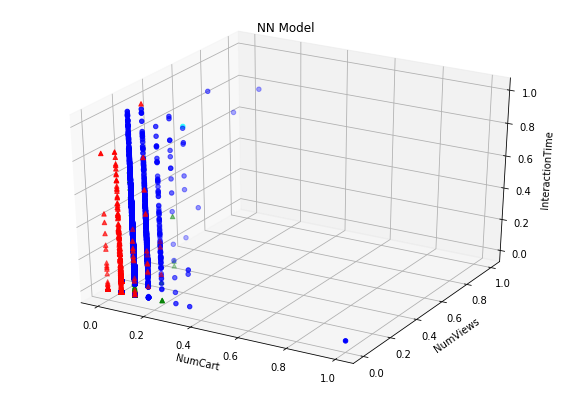

In [36]:
### START CODE HERE ###
cmnn  = confusion_matrix(y_test, nn_pred)
acc   = accuracy(y_test, nn_pred)
rec   = recall(y_test, nn_pred)
prec  = precision(y_test, nn_pred)
f1    = f1_score(y_test, nn_pred)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, F1-score = {f1:.3f}')
print('Confusion Matrix is:')
print(cmnn)
visualize_scatter_plot(X_test,y_test,nn_pred,'NN Model')

---
# Task 4: Analyze importace of data sample balancing using Random forest and visualize Decision Tree

### Instantiate, train, predict with, and evaluate an unbalanced random forest classifier

Accuracy = 0.9980652383960756, Precision = 1.0, Recall = 0.8638888888888889, F1-score = 0.9269746646795828
Confusion Matrix is:
[[424424      0]
 [   833   5287]]


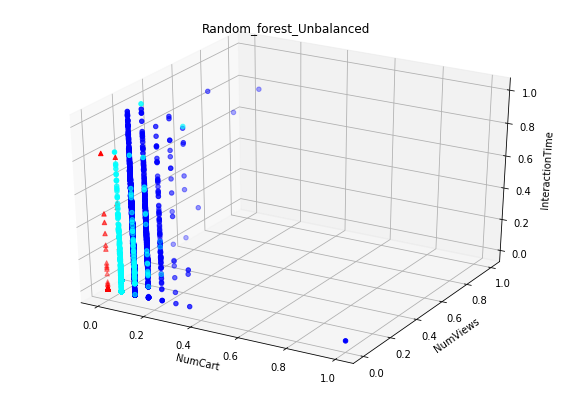

In [29]:
### START CODE HERE ###
from sklearn.ensemble import RandomForestClassifier

# Instantiate the classifier
# Set the max depth to 5 and the random state to 0
clf = RandomForestClassifier(max_depth=5, random_state=0)
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(X_test)
# Compute the confusion matrix and evaluation metrics
cm   = confusion_matrix(y_test, prediction)
acc  = accuracy(y_test, prediction)
rec  = recall(y_test, prediction)
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test, y_test, prediction, 'Random_forest_Unbalanced')

### Repeat the previous exercise, but this time, incorporate class-balanced penalty weights

Accuracy = 0.9986435764985693, Precision = 0.9241495556236592, Recall = 0.9854575163398693, F1-score = 0.9538193895302863
Confusion Matrix is:
[[423929    495]
 [    89   6031]]


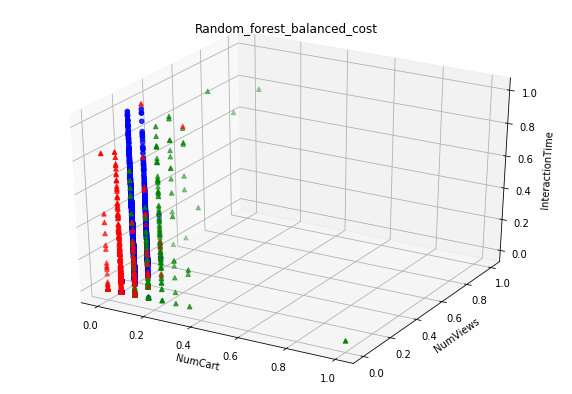

In [30]:
### START CODE HERE ###
# Instantiate the classifier
# Set the max depth to 5 and the random state to 0
clf = RandomForestClassifier(max_depth=5, random_state=0, class_weight='balanced')
# Train the classifier
clf.fit(X_train, y_train)
# Use the classifier to make predictions from the test features
prediction = clf.predict(X_test)
# Compute the confusion matrix and evaluation metrics
cm   = confusion_matrix(y_test, prediction)
acc  = accuracy(y_test, prediction)
rec  = recall(y_test, prediction)
prec = precision(y_test, prediction)
f1   = f1_score(y_test, prediction)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test,y_test,prediction,'Random_forest_balanced_cost')

### Finally, subsample the data so the two classes are equally represented when training the model

DON'T try running this in Colab. You'll get the following error message: `ValueError: object of too small depth for desired array`. It does seem to work when run locally, though.

In [31]:
yOneIdx = np.arange(0, len(y_train), dtype=np.int64)[y_train == 1]
yZeroIdx = np.random.choice(np.arange(0, len(y_train), dtype=np.int64)[y_train == 0], 
                            len(y_train[y_train == 1]))
assert len(yOneIdx) == len(yZeroIdx)
sampleIdx = np.concatenate((yOneIdx, yZeroIdx))

Accuracy = 0.9986366085696236, Precision = 0.929780953860494, Recall = 0.9779411764705882, F1-score = 0.9532531655650235
Confusion Matrix is:
[[423972    452]
 [   135   5985]]


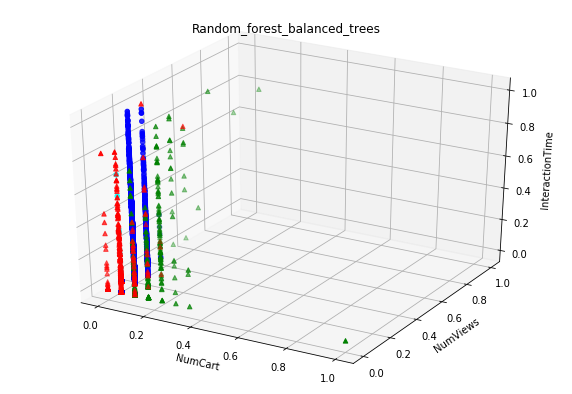

In [32]:
from imblearn.ensemble import BalancedRandomForestClassifier
### START CODE HERE ###
# Instantiate, train, and predict with the classifier
clf = BalancedRandomForestClassifier(max_depth=5, random_state=0)
clf.fit(X_train[sampleIdx], y_train[sampleIdx])
predictionBR = clf.predict(X_test)
# Compute the confusion matrix and evaluation metrics
cm   = confusion_matrix(y_test, predictionBR)
acc  = accuracy(y_test, predictionBR)
rec  = recall(y_test, predictionBR)
prec = precision(y_test, predictionBR)
f1   = f1_score(y_test, predictionBR)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc}, Precision = {prec}, Recall = {rec}, F1-score = {f1}')
print('Confusion Matrix is:')
print(cm)
visualize_scatter_plot(X_test, y_test, predictionBR, 'Random_forest_balanced_trees')

In [33]:
cols = np.array((selected_columns[:-1])).astype(str)
print(cols)

['NumOfEventsInJourney' 'interactionTime' 'maxPrice' 'NumCart' 'NumView'
 'InsessionView']


In [34]:
print(clf.estimators_[0])

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=209652396)


### Visualize the decision tree

In [35]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(
    clf.estimators_[0], 
    max_depth=5, 
    out_file='tree.dot', 
    feature_names = cols,
    rounded = True, 
    proportion = False, 
    precision = 2, 
    filled = True
)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

---
##Comment on the decision tree between balanced and unbalanced  classifiers
# Report the following:

## 1. Optimal Feature set contains X features named:
1. NumOfEventsInJourney 
1. interactionTime 
1. maxPrice 
1. NumCart 
1. NumView
1. InsessionView

### Classification performance:
| Classifier | Accuracy | Precision | Recall | F1 Score |
| :-: | :-: | :-: | :-: | :-: |
| Logistic Regression | 0.999 | 0.944 | 0.990 | 0.967 |
| Gradient Boosting | 0.999 | 0.954 | 0.982 | 0.968 |

---
# **Summary and Discussion:** **Discuss** "What would you report back as the best features and the best model for purchase prediction?" 
I would report Logistic regression as the best model and NumOfEventsInJourney as the best features. Logistic regression gives higher recall score and we would like to get as many purchase as possible. While based on the tree genereated by decision trees, NumOfEventsInJourney is the first feature used for splitting.

---
# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Can you process the data in some other way? 
2. Given a new data set on the job, how would you report the best "method"? What are the steps to always follow? 
3. What is the metric/metrics you would use to report your results?

#Share screen and discuss findings. Think about generalizability (something that works across data sets).